In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.decomposition import PCA
import deepchecks as dc
from deepchecks.tabular import Dataset
from deepchecks.tabular.suites import full_suite
import shap
from collections import Counter

# Read Data

In [4]:
data_path = "data/processed/sample_train.csv"
vt_data_path = "data/virustotal/train_vt_data.csv"

In [23]:
df = pd.read_csv(data_path)
vt_df = pd.read_csv(vt_data_path)

Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.


In [6]:
df.columns

Index(['sha256', 'md5', 'appeared', 'label', 'avclass', 'size', 'vsize',
       'has_debug', 'exports', 'imports', 'has_relocations', 'has_resources',
       'has_signature', 'has_tls', 'symbols', 'numstrings', 'avlength',
       'printables', 'entropy', 'paths', 'urls', 'registry', 'MZ'],
      dtype='object')

# Feature Engineering

In [7]:
df['has_debug_relocations_resources_signature']=df['has_debug']*df['has_relocations']*df['has_resources']*df['has_signature']

In [8]:
feature_cols = ['size', 'vsize',
                'exports', 'imports',
                'has_tls', 'symbols',
                'numstrings', 'avlength',
                'printables', 'entropy', 'paths', 'urls',
                'registry', 'MZ',
                'has_debug_relocations_resources_signature']
data_df = df[feature_cols + ['label']]

In [9]:
a = data_df.drop_duplicates()
a[a['label'] == 0].shape

(77708, 16)

# File Type Analysis

In [24]:
# convert trid to list of dictionaries
vt_df['trid'] = vt_df['trid'].apply(lambda x: eval(x))

In [30]:
vt_df['trid_len'] = vt_df['trid'].apply(lambda x: len(list(x)))
vt_df[vt_df['trid_len'] == 1]['trid'].iloc[0]

[{'file_type': 'DOS Executable Generic', 'probability': 100.0}]

In [52]:
trid_probs = {}
def update_trid_dic(trid_list):
    for trid in trid_list:
        # count 
        trid_prob_lst = trid_probs.get(trid['file_type'], [])
        trid_prob_lst.append(trid['probability'])
        trid_probs[trid['file_type']] = trid_prob_lst


In [53]:
vt_df['trid'].apply(update_trid_dic)
# convert dictionary to dataframe
trid_df = pd.DataFrame.from_dict(trid_probs, orient='index', columns=['prob_lst'])
trid_df = trid_df.reset_index().rename(columns={'index': 'file_type'})
trid_df.sort_values(by='count', ascending=False)

ValueError: 1 columns passed, passed data had 63741 columns

# Dimensionality Reduction

In [8]:
X = data_df[feature_cols].values
y = df['label'].values

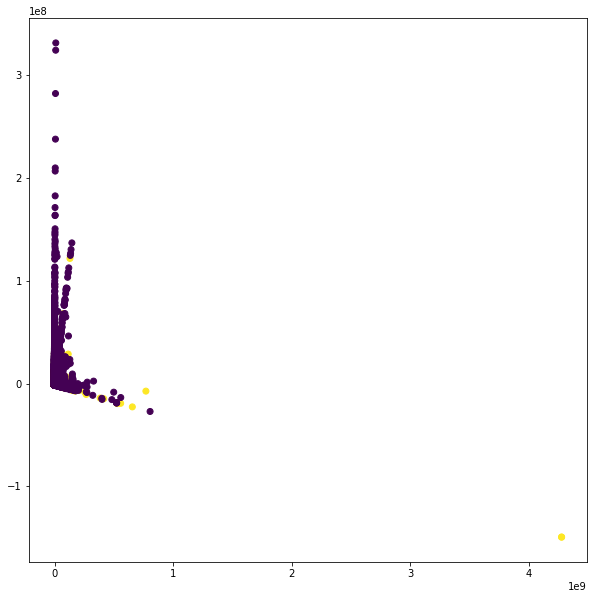

In [9]:
# perform PCA
pca = PCA()
pca.fit(X)
data_pca = pca.transform(X)
# plot the results
plt.figure(figsize=(10, 10))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=df['label'])


In [10]:
# split the data
df_train, df_test = train_test_split(data_df, test_size=0.2, stratify=data_df['label'], random_state=42)

In [11]:
# train the model
# X_train = df_train[feature_cols].values
# y_train = df_train['label'].values
X_train = df_train[feature_cols]
y_train = df_train['label']
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [26]:
# define the dataset
dc_train = Dataset(df_train, label = 'label', cat_features= [])
dc_test = Dataset(df_test, label = 'label', cat_features= [])
# define checks object
suite = full_suite()

In [28]:
suite.run(train_dataset = dc_train, test_dataset = dc_test, model = xgb_model)

Full Suite: 
 
 
 
 35/35 [Time: 01:17, Check=Identifier Label Correlation]

Accordion(children=(VBox(children=(HTML(value='\n            <h1 id="summary_HYKZ1OTLNVQZ7HEKN0RV1ZLEV">Full S…

In [35]:
# s_data = shap.maskers.Independent(X_train)

In [12]:
# plot shap values
explainer = shap.Explainer(xgb_model, X_train.iloc[:1000])
shap_values = explainer(X_train.iloc[:1000])

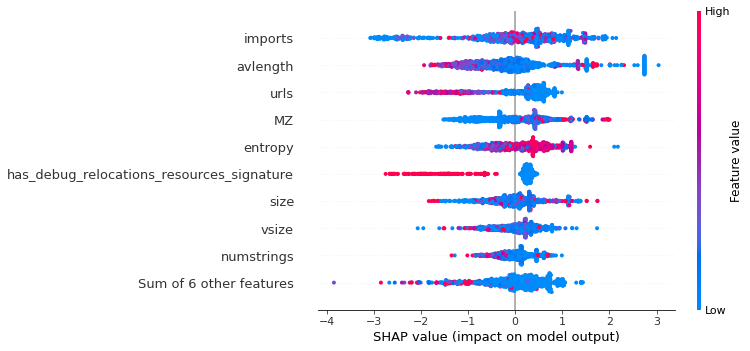

In [13]:
shap.plots.beeswarm(shap_values)